# Using Face Detection Algorithms to Protect Privacy

In the first interactive notebook explored in LSE 100, we programmed a robot, Felix, to sort cats and dogs in the correct kennels. Although Felix was not always accurate in his classifications, we were able to achieve close to 70% accuracy. This result means that out of ten guesses, seven would be correct. While this is not a perfect score, it was a pretty impressive performance when we take into consideration that a) we used a pretty simplistic method (Logistic Regression) for a complex task and b) we did not try any optimisation techniques. Well done!

<img src="cat_and_dog.JPG" alt="Drawing" style="width: 700px;"/>

Since Felix did so well in his first mission, Amanda, the shelter manager decided to assign us a new task. 
Recently a large number of pets were successfully placed into new homes, and she would like to include some happy photos of the animals with their new families to the shelter website. Since there are a lot of images, it would take a long time to track down each family to ask for their consent. On the other hand, it is important to protect each individual's privacy.

<img src="felix_photos.JPG" alt="Drawing" style="width: 300px;"/>

Amanda proposed that we find a way to detect if there are human faces in the pictures. For cases where human faces are detected, it is then possible to somehow process them to de-identify the owners.

Below you can see a list of the most recent shelter alumni, their species as well as the name of their associated image file and extension:

<img src="pet_list.JPG" alt="Drawing" style="width: 600px;"/>


Credits: Animal and robot images made using vector icons by Monkik, Smashicons and Freepik from www.flaticon.com

# How Do Face Detection Algorithms Work?

## The Viola-Jones Framework

While there is a tendency to use Deep Learning for most tasks nowadays, the most popular face recognition algorithm was developed in [2001 by Paul Viola and Michael Jones](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=990517). Although the Viola-Jones algorithms is part of a more outdated framework, it is still considered exceptional even in real-time face detection. If your phone can detect faces in your pictures, you have most likely used that algorithm before without knowing it!

## The Key Ideas Behind Viola-Jones

Viola-Jones was designed for frontal faces, which means that even though you will be able to detect faces looking sideways in many cases, you are more likely to be succesful when the person is facing the camera.

Just as we did in the first case study with the **Cat vs Dog classifier**, we have to prepare the images to make them easier for the computer to process. Converting them into grayscale reduces the amount of information which helps us accelerate computation. The Viola-Jones algorithm will first detect faces on the grayscale version of the image and then will finds the location on the colored image.

### Haar Features

Haar features are named after Alfred Haar, a Hungarian mathematician in the 19th century who developed the concept of Haar wavelets. The features below show a box with light and dark sides, which is how your computer determines possible features. Haar features are ideal for faces which are inherently made of lots of fiffferent contrasts. For example the area where your eyes are is usually overall darker or lighter than where your cheaks are. 
Another example is the area between your eyes (the nose's bridge) might be lighter or darker than your eyes. We demonstrate that idea below with Kryten from Red Dwarf.

<img src="Kryten_Features.JPG" alt="Drawing" style="width: 600px;"/>

### Training Viola-Jones

Just as we did in Cats vs Dogs, we need to train out model to be able to detect when a given feature is part of a face or not. In their seminal paper, Viola and Jones fed their algorithm 4,916 manually anotated images with faces as well as 10,000 images without faces.

The algorithm learns from the images we supply it and is able to determine the false positives and true negatives in the data, allowing it to be more accurate. Naturally, the more examples your computer has seen, the more accurate the performance will become. Training can take a very long time as the machine has to consider many possible configurations. Luckily, pre-trained model are available for us to use as part of Python packages, specifically the [Open Computer Vision Library (cv2)](https://opencv.org/).

### Reflection Point:
- Can you think of any situations where Haas features could get misleading?

# Once we have detected faces, how can we distort them to protect the owner's identity?

## Gaussian Blur
In image processing, we use Gaussian blur, also known as Gaussian smoothing to transform images by reducing their noise and consequentially their details. It is possible to apply a gaussian filter to the entire picture as well as to small subsets of our choice. 

<img src="fish_gaussian2.JPG" alt="Drawing" style="width: 600px;"/>

In Python we can easily apply Gaussian filters to images using the `GaussianBlur` function from the `skimage` library. You will see that in practice later on in this Notebook.

### Reflection Point:
- Can you think of any other situations where distorting image features can be useful?

# Getting Stated with Face Detection

When working with code you intend to share with others, it is useful to import all required libraries at the beginning of the workflow.

In [2]:
import ipywidgets as widgets
from io import BytesIO
from PIL import Image
import cv2 as cv

from skimage import data, color
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Nathalie\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Pre-Proccessing Images

The first step is to create a function that will help us import our images as well as prepare them for processing. As discussed above, Viola-Jones works best on grayscale images. FuNction `image_loader` takes an image, returns the original as well as a grayscale copy.

In [2]:
def image_loader(filename):
    original_image = cv.imread(filename)
    original_image = cv.cvtColor(original_image, cv.COLOR_BGR2RGB)
    grayscale_image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)
    
    return grayscale_image, original_image
    

Let's try it! Here we upload and process an image of Ruth the goat and her new family with our brand new function and print it out in the Notebook to make sure everything went as planned.

### Note: If you would like to try more images from our collection later you can replace "ruth.jpeg" by the name of the files you are interested in. Check out the list above!

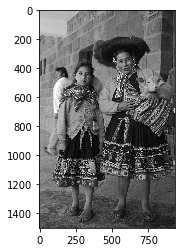

In [3]:
# Using our brand new function
grayscale_image, original_image = image_loader("ruth.jpeg")

# Use pyplot's function for showing imagens with convenience
plt.imshow(grayscale_image, cmap="gray")

**Success!**

We can also print the `original_image` to compare them.

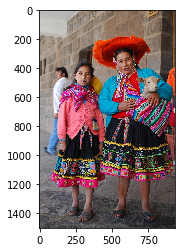

In [5]:
plt.imshow(original_image)

## Finding and Inspecting Potential Faces

This is now the most important step in our workflow. Here, we create a function called `face_detector` which looks for faces in a picture and tells you how many were found.

We will use Open CV's `CascadeClassifier` function with a pre-trained model we found in the [library](https://github.com/opencv/opencv/tree/master/data/haarcascades). The specific model we are using is called **'haarcascade_frontalface_alt'**. Although we can find versions with optimization in the library, we will stick with the original version for this tutorial.

As you will see we were able to do our detection in the grayscale image. Later on we will aply those results to the original image to get our picture back in colour.|

In [11]:
def face_detector(grayscale_image, original_image):    
    face_cascade = cv.CascadeClassifier('haarcascade_frontalface_alt.xml')
    detected_faces = face_cascade.detectMultiScale(grayscale_image)
    
    plt.imshow(original_image)
    print("I found {0} human face(s)!".format(len(detected_faces)))
    
    return detected_faces

I found 2 human face(s)!


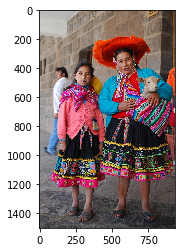

In [7]:
detected_faces = face_detector(grayscale_image, original_image)

`show_targets` looks for the coordinates from the face detection results and prints a green rectangle around what was labelled as a potential face.

In [8]:
def show_targets(grayscale_image, original_image): 
    targets = original_image.copy()
    face_cascade = cv.CascadeClassifier('haarcascade_frontalface_alt.xml')
    detected_faces = face_cascade.detectMultiScale(grayscale_image)
    
    for (column, row, width, height) in detected_faces:
        cv.rectangle(targets,(column, row),(column + width, row + height),(0, 255, 0),10)
    
    plt.imshow(targets)
    
    

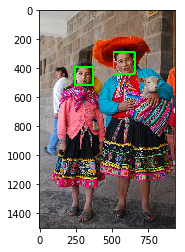

In [9]:
show_targets(grayscale_image, original_image)

**Great work!** For this picture, we were able to detect the two human faces present in the picture accurately. We also did not mistake the goat for a person – extra brownie points for us!


Since we have just started experimenting with our new function, we will create an additional module that will return the subsets of the image that were labelled as potential faces to inspect them closer.


In [10]:
def show_individuals(grayscale_image, original_image):
    face_cascade = cv.CascadeClassifier('haarcascade_frontalface_alt.xml')
    detected_faces = face_cascade.detectMultiScale(grayscale_image)
    for (x, y, w, h) in detected_faces:
        r = max(w, h) / 2
        centerx = x + w / 2
        centery = y + h / 2
        nx = int(centerx - r)
        ny = int(centery - r)
        nr = int(r * 2)


        plt.figure(figsize=(3,2))
        plt.imshow(original_image[ny:ny+nr, nx:nx+nr])


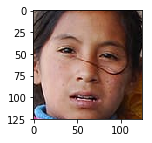

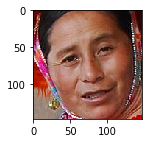

In [11]:
show_individuals(grayscale_image, original_image)

The results are spot on for this image! In both cases we obtain the entire face. It is important to remember that Viola-Jones works best when individuals face the camera. Perhaps if one person was tilting or facing another direction we would not be as succesful.

## Blurring Features

Now that we know where we could potentially find a face in the picture, we can finally use a Gaussian Blur filter to distort its features. Now it should be more difficult to recognize the individuals.

In [12]:
def blurred_faces(detected_faces, original_image):    
    result_image = original_image.copy()

    if len(detected_faces) != 0:         # If there are faces in the images
        for f in detected_faces:         # For each face in the image

            # Get the origin co-ordinates and the length and width till where the face extends
            x,y,w,h = f

            # get the rectangle img around all the faces
            cv.rectangle(original_image, (x,y), (x+w,y+h), 10)
            sub_face = original_image[y:y+h, x:x+w]
            # apply a gaussian blur on this new recangle image
            sub_face = cv.GaussianBlur(sub_face,(43, 43), 30)
            # merge this blurry rectangle to our final image
            result_image[y:y+sub_face.shape[0], x:x+sub_face.shape[1]] = sub_face
            #face_file_name = "./face_" + str(y) + ".jpg"
            plt.imshow(result_image)
        

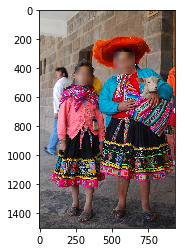

In [13]:
blurred_faces(detected_faces, original_image)

**Fantastic!** Both the woman and the girl are now unrecognisable while Ruth is fully visible.

**Our workflow is ready for deployment!**

To facilitate going from the original image to the final blurred picture we summarize all the steps we just went through in two simpler functions. When you run them, you should find the same outputs.


In [14]:
def detection(filename):
    processed_image, original_image = image_loader(filename)
    detected_faces = face_detector(processed_image, original_image)
    show_targets(processed_image, original_image)

In [15]:
def complete_workflow(filename):
    processed_image, original_image = image_loader(filename)
    detected_faces = face_detector(processed_image, original_image)
    show_targets(processed_image, original_image)
    blurred_faces(detected_faces, original_image)
    

I found 2 human face(s)!


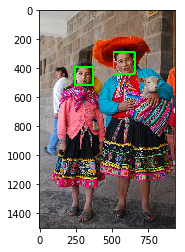

In [16]:
detection("ruth.jpeg")

I found 2 human face(s)!


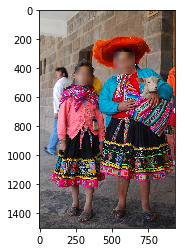

In [17]:
complete_workflow("ruth.jpeg")

Everything works great. Feel free to try other images from the folder with both `detection` and `complete_workflow` to see how our programme does with the other pet images. Some will work better that others but you will find interesting patterns when things do not go quite as expected.

### Reflection Point:

- Which pictures don't work as well? Do they share any characteristics?
- How could we improve conditions for Viola-Jones?

# Your Turn! Upload Your Images Here Using the 'Upload' Button.

Here you can try any image you want from your computer by following these step-by-step instructions.

### Step 1: Run the next cell for the 'Upload' button to show up then select a picture from your computer

In [3]:
upload = widgets.FileUpload(accept='image/*', multiple=False)
upload

FileUpload(value={}, accept='image/*', description='Upload')

### Step 2: Run the next three cells. During this step we process the image to make sure it is now in the right format for our workflow specifications

In [4]:
filename = next(iter(upload.value.keys()))
filedata = upload.value[filename]['content']

In [5]:
stream = BytesIO(filedata)
image = Image.open(stream)

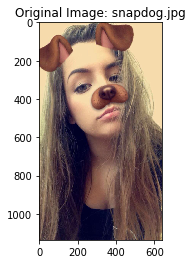

In [6]:
f = plt.figure()
plt.title(f"Original Image: {filename}")  # TODO: Update this string with your model output
plt.imshow(image)

### Step 3: Run the next three cells to initiate all the funtion we will need - While they look a lot like the ones we made previously, these ones account for the fact that the image format can be a bit different from user to user

In [7]:
def image_reader(filename):
    original_image = np.array(filename) 
    grayscale_image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)
    
    return grayscale_image, original_image

In [8]:
def detection_uploader(filename):
    processed_image, original_image = image_reader(filename)
    detected_faces = face_detector(processed_image, original_image)
    show_targets(processed_image, original_image)

In [9]:
def complete_workflow_uploader(filename):
    processed_image, original_image = image_reader(filename)
    detected_faces = face_detector(processed_image, original_image)
    show_targets(processed_image, original_image)
    blurred_faces(detected_faces, original_image)

### Step 4: Detect! 

I found 0 human face(s)!


NameError: name 'show_targets' is not defined

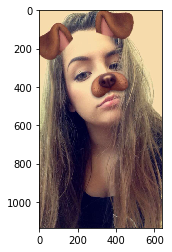

In [12]:
detection_uploader(image)

### Step 5: Blur!

I found 4 human face(s)!


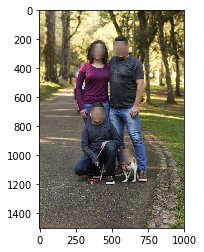

In [45]:
complete_workflow_uploader(image)

If you want to keep the blurred image as a souvenir you can run the next cell. This will create a copy in your binder as 'blurred_image'.

### Step 6: Share with friends

Hashtag?

# We hope you had fun!